In [246]:
import pandas as pd
import numpy as np
import matplotlib as sns
import seaborn as sns

In [247]:
train = pd.read_csv('/home/kanja/Downloads/loan-default-prediction/trainperf.csv', parse_dates=['approveddate', 'creationdate'])
train.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby,good_bad_flag
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56,2017-07-25 07:22:47,30000.0,34500.0,30,NaN,Good
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,2017-07-05 17:04:41,2017-07-05 16:04:18,15000.0,17250.0,30,NaN,Good
2,8a8588f35438fe12015444567666018e,301966580,7,2017-07-06 14:52:57,2017-07-06 13:52:51,20000.0,22250.0,15,NaN,Good
3,8a85890754145ace015429211b513e16,301999343,3,2017-07-27 19:00:41,2017-07-27 18:00:35,10000.0,11500.0,15,NaN,Good
4,8a858970548359cc0154883481981866,301962360,9,2017-07-03 23:42:45,2017-07-03 22:42:39,40000.0,44000.0,30,NaN,Good


In [248]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV

In [249]:
train['diff_h'] = (train['approveddate'].dt.hour - train['creationdate'].dt.hour)
train['diff_m'] = (train['approveddate'].dt.minute - train['creationdate'].dt.minute)
train['diff_s'] = (train['approveddate'].dt.second - train['creationdate'].dt.second)
train['diff_s'] = round(train['diff_s']/60, 2)
train['diff_m'] = round(train['diff_m']/60, 2)
train['timetaken'] = train['diff_h'].astype(float) + train['diff_m'] +train['diff_s']

In [250]:
good_bad_flag = pd.get_dummies(train['good_bad_flag'])
train = pd.concat((good_bad_flag, train), axis=1)
train = train.drop(['good_bad_flag'], axis=1)
train =train.drop(['Bad'],axis=1)
train = train.rename(columns={'Good':'good_bad_flag'})
train.head()

,good_bad_flag,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby,diff_h,diff_m,diff_s,timetaken
0,1,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56,2017-07-25 07:22:47,30000.0,34500.0,30,NaN,1,0.0,0.15,1.15
1,1,8a85886e54beabf90154c0a29ae757c0,301965204,2,2017-07-05 17:04:41,2017-07-05 16:04:18,15000.0,17250.0,30,NaN,1,0.0,0.38,1.38
2,1,8a8588f35438fe12015444567666018e,301966580,7,2017-07-06 14:52:57,2017-07-06 13:52:51,20000.0,22250.0,15,NaN,1,0.0,0.10,1.10
3,1,8a85890754145ace015429211b513e16,301999343,3,2017-07-27 19:00:41,2017-07-27 18:00:35,10000.0,11500.0,15,NaN,1,0.0,0.10,1.10
4,1,8a858970548359cc0154883481981866,301962360,9,2017-07-03 23:42:45,2017-07-03 22:42:39,40000.0,44000.0,30,NaN,1,0.0,0.10,1.10


In [251]:
features = ['timetaken','loannumber','totaldue','loanamount','termdays']
X = train[features]
y = train.good_bad_flag
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, stratify=y)

In [252]:
log_model = LogisticRegression()
grid = {'C':10.0**np.arange(-2, 3),
       'penalty':['l1','l2']}
cv = KFold(n_splits=5,shuffle=False,random_state=None)
clf = GridSearchCV(log_model, grid, cv=cv, n_jobs=-1,scoring='f1_macro')
clf.fit(X_train, y_train)

/home/kanja/datascience/zindi/env/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/home/kanja/datascience/zindi/env/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kanja/datascience/zindi/env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/kanja/datascience/zindi/env/lib/python3.10/site-packages/sklearn/l

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'penalty': ['l1', 'l2']},
             scoring='f1_macro')

In [253]:
y_pred = clf.predict(X_test)
print(f"{confusion_matrix(y_test, y_pred)}")
print()
print(f'accuracy: {accuracy_score(y_test,y_pred)}')
print()
print(f'classification report: {classification_report(y_pred, y_test)}')

[[  0 238]
 [  0 854]]

accuracy: 0.782051282051282

classification report:               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.78      0.88      1092

    accuracy                           0.78      1092
   macro avg       0.50      0.39      0.44      1092
weighted avg       1.00      0.78      0.88      1092



/home/kanja/datascience/zindi/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kanja/datascience/zindi/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kanja/datascience/zindi/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [254]:
test = pd.read_csv('/home/kanja/Downloads/loan-default-prediction/testperf.csv')
test['creationdate'] = pd.to_timedelta(test['creationdate'].str.replace('.',':'))
test['approveddate'] = pd.to_timedelta(test['approveddate'].str.replace('.',':'))

/tmp/ipykernel_17588/1728254883.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  test['creationdate'] = pd.to_timedelta(test['creationdate'].str.replace('.',':'))
/tmp/ipykernel_17588/1728254883.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  test['approveddate'] = pd.to_timedelta(test['approveddate'].str.replace('.',':'))


In [255]:
test['approvedhours'] = pd.to_timedelta(test.approveddate, errors='coerce').dt.total_seconds()/3600
test['creationhours'] = pd.to_timedelta(test.creationdate, errors='coerce').dt.total_seconds()/3600
test['timetaken'] = test['approvedhours'] - test['creationhours']
test.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby,approvedhours,creationhours,timetaken
0,8a858899538ddb8e015390510b321f08,301998974,4,1 days 16:48:00,1 days 15:35:00,10000,12250.0,30,NaN,40.800000,39.583333,1.216667
1,8a858959537a097401537a4e316e25f7,301963615,10,1 days 19:40:00,1 days 18:34:00,40000,44000.0,30,NaN,43.666667,42.566667,1.100000
2,8a8589c253ace09b0153af6ba58f1f31,301982236,6,0 days 15:11:00,0 days 15:04:00,20000,24500.0,30,NaN,15.183333,15.066667,0.116667
3,8a858e095aae82b7015aae86ca1e030b,301971730,8,0 days 00:54:00,0 days 00:49:00,30000,34500.0,30,NaN,0.900000,0.816667,0.083333
4,8a858e225a28c713015a30db5c48383d,301959177,4,0 days 04:33:00,0 days 04:27:00,20000,24500.0,30,NaN,4.550000,4.450000,0.100000


In [256]:
true_test = test[features]
predictions = clf.predict(true_test)
submission = pd.read_csv('/home/kanja/Downloads/loan-default-prediction/SampleSubmission.csv')
sub_file = submission.copy()
sub_file.good_bad_flag = predictions

/tmp/ipykernel_17588/1238953224.py:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  sub_file.good_bad_flag = predictions


/home/kanja/datascience/zindi/env/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Predictions Data Distributions')

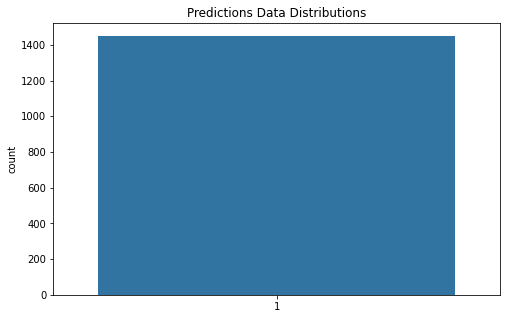

In [257]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
sns.countplot(sub_file.good_bad_flag)
plt.title('Predictions Data Distributions')

In [258]:
sub_file.to_csv('testsubmission.csv', index = False)

In [259]:
from sklearn.ensemble import RandomForestClassifier

In [260]:
rand_model = RandomForestClassifier()
grid = [{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
{'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},]
cv = KFold(n_splits=5,shuffle=False,random_state=None)
clf = GridSearchCV(rand_model, grid, cv=cv, n_jobs=-1,scoring='f1_macro')
clf.fit(X_train, y_train)

/home/kanja/datascience/zindi/env/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/home/kanja/datascience/zindi/env/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kanja/datascience/zindi/env/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 450, in fit
    trees = Parallel(
  File "/home/kanja/datascience/zindi/env/lib/python3.10/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dis

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             scoring='f1_macro')

In [261]:
y_pred = clf.predict(X_test)
print(f"{confusion_matrix(y_test, y_pred)}")
print()
print(f'accuracy: {accuracy_score(y_test,y_pred)}')
print()
print(f'classification report: {classification_report(y_pred, y_test)}')

[[ 30 208]
 [ 94 760]]

accuracy: 0.7234432234432234

classification report:               precision    recall  f1-score   support

           0       0.13      0.24      0.17       124
           1       0.89      0.79      0.83       968

    accuracy                           0.72      1092
   macro avg       0.51      0.51      0.50      1092
weighted avg       0.80      0.72      0.76      1092



/tmp/ipykernel_17588/4012462908.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  sub_file.good_bad_flag = predictions
/home/kanja/datascience/zindi/env/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Predictions Data Distributions')

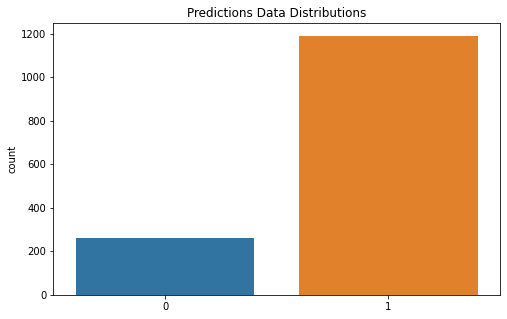

In [262]:
predictions = clf.predict(true_test)
sub_file = submission.copy()
sub_file.good_bad_flag = predictions
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
sns.countplot(sub_file.good_bad_flag)
plt.title('Predictions Data Distributions')

In [263]:
sub_file.to_csv('randomsubmission.csv', index = False)

### undersampling

In [264]:
from imblearn.under_sampling import NearMiss
features = ['timetaken','loannumber','totaldue','loanamount','termdays']
X = train[features]
y = train.good_bad_flag

In [265]:
ns = NearMiss(0.8)
X_ns, y_ns = ns.fit_resample(X, y)

/home/kanja/datascience/zindi/env/lib/python3.10/site-packages/imblearn/utils/_validation.py:586: FutureWarning: Pass sampling_strategy=0.8 as keyword args. From version 0.9 passing these as positional arguments will result in an error
  warnings.warn(


In [266]:
y_ns.value_counts()

1    1190
0     952
Name: good_bad_flag, dtype: int64

In [267]:
X_train, X_test, y_train, y_test = train_test_split(X_ns,y_ns,test_size=0.25, stratify=y_ns)
log_model = LogisticRegression()
grid = {'C':10.0**np.arange(-2, 3),
       'penalty':['l1','l2']}
cv = KFold(n_splits=5,shuffle=False,random_state=None)
clf = GridSearchCV(log_model, grid, cv=cv, n_jobs=-1,scoring='f1_macro')
clf.fit(X_train, y_train)

/home/kanja/datascience/zindi/env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/kanja/datascience/zindi/env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'penalty': ['l1', 'l2']},
             scoring='f1_macro')

In [268]:
y_pred = clf.predict(X_test)
print(f"{confusion_matrix(y_test, y_pred)}")
print()
print(f'accuracy: {accuracy_score(y_test,y_pred)}')
print()
print(f'{classification_report(y_pred, y_test)}')

[[105 133]
 [ 49 249]]

accuracy: 0.6604477611940298

              precision    recall  f1-score   support

           0       0.44      0.68      0.54       154
           1       0.84      0.65      0.73       382

    accuracy                           0.66       536
   macro avg       0.64      0.67      0.63       536
weighted avg       0.72      0.66      0.68       536



/tmp/ipykernel_17588/4012462908.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  sub_file.good_bad_flag = predictions
/home/kanja/datascience/zindi/env/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Predictions Data Distributions')

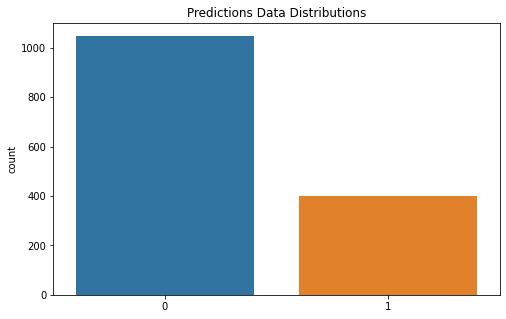

In [269]:
predictions = clf.predict(true_test)
sub_file = submission.copy()
sub_file.good_bad_flag = predictions
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
sns.countplot(sub_file.good_bad_flag)
plt.title('Predictions Data Distributions')

In [270]:
sub_file.to_csv('undersamplingsubmission.csv', index = False)

In [271]:
rand_model = RandomForestClassifier()
grid = [{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
{'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},]
cv = KFold(n_splits=5,shuffle=False,random_state=None)
classifier = GridSearchCV(rand_model, grid, cv=cv, n_jobs=-1,scoring='f1_macro')
classifier.fit(X_train, y_train)

/home/kanja/datascience/zindi/env/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/home/kanja/datascience/zindi/env/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kanja/datascience/zindi/env/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 450, in fit
    trees = Parallel(
  File "/home/kanja/datascience/zindi/env/lib/python3.10/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dis

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             scoring='f1_macro')

In [272]:
y_pred = classifier.predict(X_test)
print(f"{confusion_matrix(y_test, y_pred)}")
print()
print(f'accuracy: {accuracy_score(y_test,y_pred)}')
print()
print(f'{classification_report(y_pred, y_test)}')

[[115 123]
 [ 17 281]]

accuracy: 0.7388059701492538

              precision    recall  f1-score   support

           0       0.48      0.87      0.62       132
           1       0.94      0.70      0.80       404

    accuracy                           0.74       536
   macro avg       0.71      0.78      0.71       536
weighted avg       0.83      0.74      0.76       536



/tmp/ipykernel_17588/1383044891.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  sub_file.good_bad_flag = predictions
/home/kanja/datascience/zindi/env/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Predictions Data Distributions')

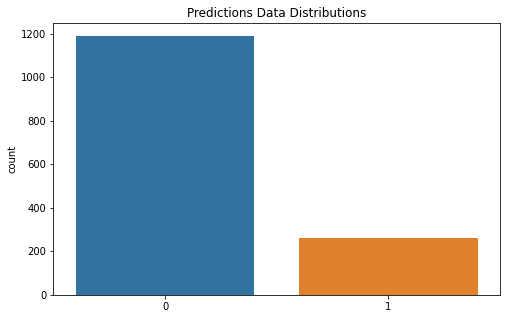

In [273]:
predictions = classifier.predict(true_test)
sub_file = submission.copy()
sub_file.good_bad_flag = predictions
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
sns.countplot(sub_file.good_bad_flag)
plt.title('Predictions Data Distributions')

In [274]:
sub_file.to_csv('fore_ranundersamplingsubmission.csv', index = False)

### oversampling

In [275]:
from imblearn.over_sampling import RandomOverSampler
over = RandomOverSampler(0.7)
X_xs, y_xs = over.fit_resample(X,y)

/home/kanja/datascience/zindi/env/lib/python3.10/site-packages/imblearn/utils/_validation.py:586: FutureWarning: Pass sampling_strategy=0.7 as keyword args. From version 0.9 passing these as positional arguments will result in an error
  warnings.warn(


In [276]:
y_xs.value_counts()

1    3416
0    2391
Name: good_bad_flag, dtype: int64

In [277]:
X_train, X_test, y_train, y_test = train_test_split(X_xs,y_xs,test_size=0.25, stratify=y_xs)
log_model = LogisticRegression()
grid = {'C':10.0**np.arange(-2, 3),
       'penalty':['l1','l2']}
cv = KFold(n_splits=5,shuffle=False,random_state=None)
clf = GridSearchCV(log_model, grid, cv=cv, n_jobs=-1,scoring='f1_macro')
clf.fit(X_train, y_train)

/home/kanja/datascience/zindi/env/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/home/kanja/datascience/zindi/env/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kanja/datascience/zindi/env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/kanja/datascience/zindi/env/lib/python3.10/site-packages/sklearn/l

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'penalty': ['l1', 'l2']},
             scoring='f1_macro')

In [278]:
y_pred = clf.predict(X_test)
print(f"{confusion_matrix(y_test, y_pred)}")
print()
print(f'accuracy: {accuracy_score(y_test,y_pred)}')
print()
print(f'{classification_report(y_pred, y_test)}')

[[297 301]
 [279 575]]

accuracy: 0.6005509641873278

              precision    recall  f1-score   support

           0       0.50      0.52      0.51       576
           1       0.67      0.66      0.66       876

    accuracy                           0.60      1452
   macro avg       0.58      0.59      0.59      1452
weighted avg       0.60      0.60      0.60      1452



/tmp/ipykernel_17588/4012462908.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  sub_file.good_bad_flag = predictions
/home/kanja/datascience/zindi/env/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Predictions Data Distributions')

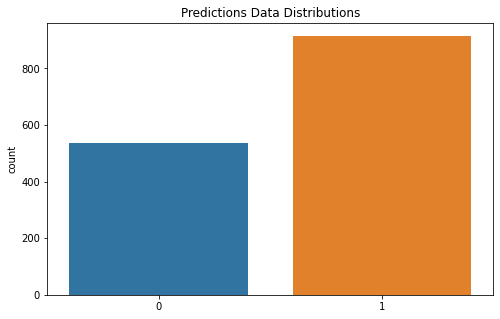

In [279]:
predictions = clf.predict(true_test)
sub_file = submission.copy()
sub_file.good_bad_flag = predictions
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
sns.countplot(sub_file.good_bad_flag)
plt.title('Predictions Data Distributions')

In [280]:
sub_file.to_csv('oversamplingsubmission.csv', index = False)

In [281]:
rand_model = RandomForestClassifier()
grid = [{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
{'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},]
cv = KFold(n_splits=5,shuffle=False,random_state=None)
classifier = GridSearchCV(rand_model, grid, cv=cv, n_jobs=-1,scoring='f1_macro')
classifier.fit(X_train, y_train)

/home/kanja/datascience/zindi/env/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/home/kanja/datascience/zindi/env/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kanja/datascience/zindi/env/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 450, in fit
    trees = Parallel(
  File "/home/kanja/datascience/zindi/env/lib/python3.10/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dis

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             scoring='f1_macro')

In [282]:
y_pred = classifier.predict(X_test)
print(f"{confusion_matrix(y_test, y_pred)}")
print()
print(f'accuracy: {accuracy_score(y_test,y_pred)}')
print()
print(f'{classification_report(y_pred, y_test)}')

[[268 330]
 [206 648]]

accuracy: 0.6308539944903582

              precision    recall  f1-score   support

           0       0.45      0.57      0.50       474
           1       0.76      0.66      0.71       978

    accuracy                           0.63      1452
   macro avg       0.60      0.61      0.60      1452
weighted avg       0.66      0.63      0.64      1452



/tmp/ipykernel_17588/1383044891.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  sub_file.good_bad_flag = predictions
/home/kanja/datascience/zindi/env/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Predictions Data Distributions')

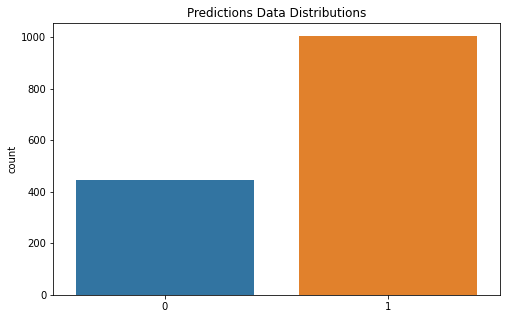

In [283]:
predictions = classifier.predict(true_test)
sub_file = submission.copy()
sub_file.good_bad_flag = predictions
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
sns.countplot(sub_file.good_bad_flag)
plt.title('Predictions Data Distributions')

In [284]:
sub_file.to_csv('fore_randoversamplingsubmission.csv', index = False)

### smoteTOMek

In [285]:
X = train[features]
y = train.good_bad_flag
from imblearn.combine import SMOTETomek
smotetome = SMOTETomek(0.55)
X_n, y_n = smotetome.fit_resample(X, y)
y_n.value_counts()

/home/kanja/datascience/zindi/env/lib/python3.10/site-packages/imblearn/utils/_validation.py:586: FutureWarning: Pass sampling_strategy=0.55 as keyword args. From version 0.9 passing these as positional arguments will result in an error
  warnings.warn(


1    3349
0    1811
Name: good_bad_flag, dtype: int64

In [286]:
X_train, X_test, y_train, y_test = train_test_split(X_n,y_n,test_size=0.25, stratify=y_n)
log_model = LogisticRegression()
grid = {'C':10.0**np.arange(-2, 3),
       'penalty':['l1','l2']}
cv = KFold(n_splits=5,shuffle=False,random_state=None)
clf = GridSearchCV(log_model, grid, cv=cv, n_jobs=-1,scoring='f1_macro')
clf.fit(X_train, y_train)

/home/kanja/datascience/zindi/env/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/home/kanja/datascience/zindi/env/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kanja/datascience/zindi/env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/kanja/datascience/zindi/env/lib/python3.10/site-packages/sklearn/l

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'penalty': ['l1', 'l2']},
             scoring='f1_macro')

In [287]:
y_pred = clf.predict(X_test)
print(f"{confusion_matrix(y_test, y_pred)}")
print()
print(f'accuracy: {accuracy_score(y_test,y_pred)}')
print()
print(f'{classification_report(y_pred, y_test)}')

[[  0 453]
 [  0 837]]

accuracy: 0.6488372093023256

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.65      0.79      1290

    accuracy                           0.65      1290
   macro avg       0.50      0.32      0.39      1290
weighted avg       1.00      0.65      0.79      1290



/home/kanja/datascience/zindi/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kanja/datascience/zindi/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kanja/datascience/zindi/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/tmp/ipykernel_17588/4012462908.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  sub_file.good_bad_flag = predictions
/home/kanja/datascience/zindi/env/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Predictions Data Distributions')

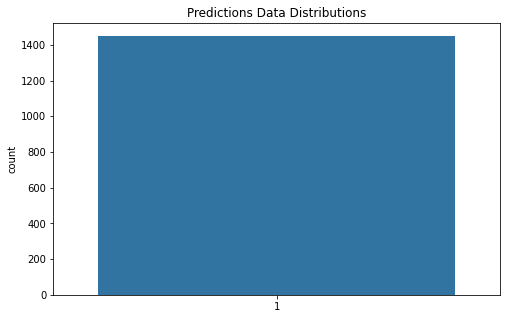

In [288]:
predictions = clf.predict(true_test)
sub_file = submission.copy()
sub_file.good_bad_flag = predictions
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
sns.countplot(sub_file.good_bad_flag)
plt.title('Predictions Data Distributions')

In [289]:
rand_model = RandomForestClassifier()
grid = [{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
{'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},]
cv = KFold(n_splits=5,shuffle=False,random_state=None)
classifier = GridSearchCV(rand_model, grid, cv=cv, n_jobs=-1,scoring='f1_macro')
classifier.fit(X_train, y_train)

/home/kanja/datascience/zindi/env/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/home/kanja/datascience/zindi/env/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kanja/datascience/zindi/env/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 450, in fit
    trees = Parallel(
  File "/home/kanja/datascience/zindi/env/lib/python3.10/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dis

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             scoring='f1_macro')

In [290]:
y_pred = classifier.predict(X_test)
print(f"{confusion_matrix(y_test, y_pred)}")
print()
print(f'accuracy: {accuracy_score(y_test,y_pred)}')
print()
print(f'{classification_report(y_pred, y_test)}')

[[150 303]
 [106 731]]

accuracy: 0.6829457364341085

              precision    recall  f1-score   support

           0       0.33      0.59      0.42       256
           1       0.87      0.71      0.78      1034

    accuracy                           0.68      1290
   macro avg       0.60      0.65      0.60      1290
weighted avg       0.77      0.68      0.71      1290



/tmp/ipykernel_17588/4012462908.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  sub_file.good_bad_flag = predictions
/home/kanja/datascience/zindi/env/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Predictions Data Distributions')

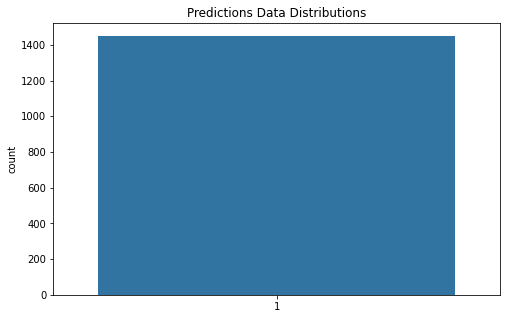

In [291]:
predictions = clf.predict(true_test)
sub_file = submission.copy()
sub_file.good_bad_flag = predictions
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
sns.countplot(sub_file.good_bad_flag)
plt.title('Predictions Data Distributions')